In [ ]:
# !pip install pretrainedmodels==0.7.4
# !pip install efficientnet-pytorch==0.6.3
# !pip install timm==0.3.2

In [ ]:
# # CUDA 11.1
# !pip install torch==1.8.0 torchvision==0.9.0 torchaudio==0.8.0

In [ ]:
# RMSE -> MAE Loss 꿀팁!!

In [6]:
!nvidia-smi

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"

Tue Nov  9 04:26:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 8000     On   | 00000000:18:00.0 Off |                  Off |
| 43%   67C    P2   250W / 260W |   6102MiB / 48601MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Quadro RTX 8000     On   | 00000000:3B:00.0 Off |                  Off |
| 33%   

In [7]:
cd /workspace/sunggu/4.Dose_img2img/scripts study

/workspace/sunggu/4.Dose_img2img/scripts study


In [8]:
import torch
print(torch.__version__)

1.8.0+cu111


In [9]:
import multiprocessing
print("CPU 갯수 = ", multiprocessing.cpu_count())

CPU 갯수 =  48


In [213]:
def dicom_normalize(image, MIN_HU=-1024.0, MAX_HU=3071.0):   # I already check the max value is 3071.0
   image = (image - MIN_HU) / (MAX_HU - MIN_HU)   # Range  0.0 ~ 1.0
#    image = (image - 0.5) / 0.5                  # Range -1.0 ~ 1.0   @ We do not use -1~1 range becuase there is no Tanh act.
   return image


In [37]:
import torch.nn as nn 
class SobelOperator(nn.Module):
    def __init__(self, epsilon=1e-4):
        super().__init__()
        self.epsilon = epsilon

        self.register_buffer('conv_x', torch.Tensor([[1, 0, -1], [2, 0, -2], [1, 0, -1]])[None, None, :, :] / 4)
        self.register_buffer('conv_y', torch.Tensor([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])[None, None, :, :] / 4)

    def forward(self, x):
        b, c, h, w = x.shape
        if c > 1:
            x = x.view(b * c, 1, h, w)

        grad_x = F.conv2d(x, self.conv_x, bias=None, stride=1, padding=1)
        grad_y = F.conv2d(x, self.conv_y, bias=None, stride=1, padding=1)

        x = torch.sqrt(grad_x**2 + grad_y**2 + self.epsilon)

        x = x.view(b, c, h, w)

        return x

In [39]:
import torch
sobel = SobelOperator()

In [17]:
def dicom_denormalize(image, MIN_HU=-1024.0, MAX_HU=3071.0):
    # image = (image - 0.5) / 0.5           # Range -1.0 ~ 1.0   @ We do not use -1~1 range becuase there is no Tanh act.
    image = (MAX_HU - MIN_HU)*image + MIN_HU
    return image


In [29]:
import numpy as np
import matplotlib.pyplot as plt

In [406]:
p = np.load('/workspace/sunggu/4.Dose_img2img/WGAN_VGG_output1.npy')
g = np.load('/workspace/sunggu/4.Dose_img2img/input_n_201.npy')

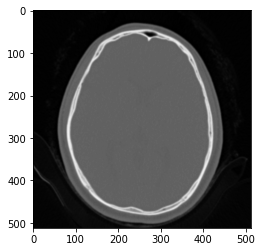

In [410]:
plt.imshow(g.squeeze(), 'gray')

In [ ]:
        # Initialize by xavier_uniform_
        self.init_weight()
        
def init_weight(self):
    print("inintializing...!")
    for m in self.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            m.weight.data.fill_(1)
            m.bias.data.zero_()

In [507]:
def dicom_normalize(image, MIN_HU=-1024.0, MAX_HU=3071.0):   # I already check the max value is 3071.0
   image = (image - MIN_HU) / (MAX_HU - MIN_HU)   # Range  0.0 ~ 1.0
#    image = (image - 0.5) / 0.5                  # Range -1.0 ~ 1.0   @ We do not use -1~1 range becuase there is no Tanh act.
   return image

In [518]:
dicom_normalize(0)

0.25006105006105006

In [519]:
dicom_normalize(80)

0.2695970695970696

In [ ]:
-155

In [ ]:
195

In [537]:
class Window_Conv2D(nn.Module):
        
    def __init__(self, mode, out_channels=5):
        super(Window_Conv2D, self).__init__()
        self.out_channels = out_channels
        self.conv_layer   = nn.Conv2d(in_channels=1, out_channels=out_channels, kernel_size=1, stride=1, padding=0, bias=True)
        
        if mode == "relu":
            self.act_layer = self.upbound_relu
        elif mode == "sigmoid":
            self.act_layer = self.upbound_sigmoid
        else:
            raise Exception()
        
        # Initialize by xavier_uniform_
        self.init_weight()
        
    def upbound_relu(self, x):
        return torch.minimum(torch.maximum(x, torch.tensor(0)), torch.tensor(1.0))

    def upbound_sigmoid(self, x):
        return 1.0 * torch.sigmoid(x)
                    
    def init_weight(self):
        print("inintializing...!")
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):        
                for idx in range(self.out_channels):
                    if idx % 5 == 0:                       
                        nn.init.constant_(m.weight[0, :, :, :], 50.0)  # torch.Size([5, 1, 1, 1])
                        nn.init.constant_(m.bias[0], -12.5)               # torch.Size([5])                  
                    elif idx % 5 == 1:                       
                        nn.init.constant_(m.weight[1, :, :, :], 31.250)  # torch.Size([5, 1, 1, 1])
                        nn.init.constant_(m.bias[1], -7.687)               # torch.Size([5])                  
                    elif idx % 5 == 2:                       
                        nn.init.constant_(m.weight[2, :, :, :], 45.455)  # torch.Size([5, 1, 1, 1])
                        nn.init.constant_(m.bias[2], -11.682)               # torch.Size([5])                  
                    elif idx % 5 == 3:                       
                        nn.init.constant_(m.weight[3, :, :, :], 1.464)  # torch.Size([5, 1, 1, 1])
                        nn.init.constant_(m.bias[3], -0.081)               # torch.Size([5])                  
                    elif idx % 5 == 4:                       
                        nn.init.constant_(m.weight[4, :, :, :], 11.628)  # torch.Size([5, 1, 1, 1])
                        nn.init.constant_(m.bias[4], -2.465)               # torch.Size([5])                  
                    else :                       
                        raise Exception()
                                     
    def forward(self, x):
        x = self.conv_layer(x)
        x = self.act_layer(x)
        return x
    
    def inference(self, x):
        self.eval()
        with torch.no_grad():
            x = self.conv_layer(x)
            x = self.act_layer(x)
        return x    

In [540]:
window_conv = Window_Conv2D(mode='relu')

inintializing...!


In [549]:
z = window_conv.inference(torch.tensor(g))

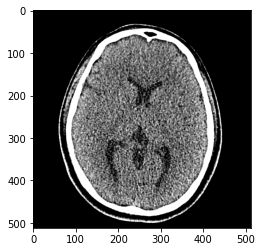

In [551]:
plt.imshow(z.detach().cpu().squeeze()[0], 'gray')

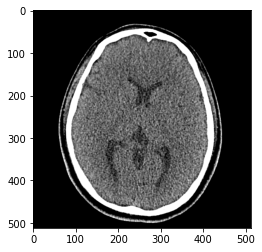

In [552]:
plt.imshow(z.detach().cpu().squeeze()[1], 'gray')

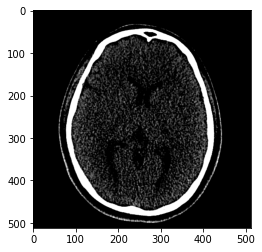

In [553]:
plt.imshow(z.detach().cpu().squeeze()[2], 'gray')

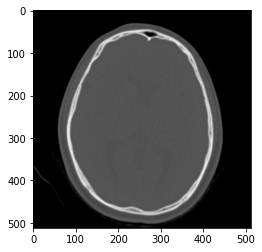

In [554]:
plt.imshow(z.detach().cpu().squeeze()[3], 'gray')

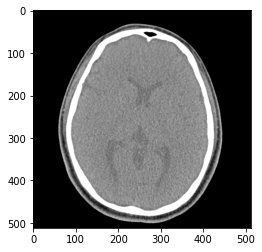

In [555]:
plt.imshow(z.detach().cpu().squeeze()[4], 'gray')

In [43]:
import torch.nn.functional as F
k = sobel(torch.tensor(g))

In [308]:
p = np.stack([np.load(i) for i in glob.glob('/workspace/sunggu/4.Dose_img2img/WGAN_VGG_output*.npy')], axis=0).squeeze(1)
g = np.stack([np.load(i) for i in glob.glob('/workspace/sunggu/4.Dose_img2img/input_n_20*.npy')], axis=0).squeeze(1)

In [309]:
p.shape

(15, 1, 512, 512)

In [284]:
import scipy
from scipy import ndimage

In [285]:
import skimage
import skimage.measure
from skimage.morphology import disk, remove_small_objects

In [299]:
image = g
bone_thresh = 0.120
image[image >= 0.120] = 1.0
image[image < 0.120]  = 0.0


In [300]:
def extract_label_mask(input_mask, target_value=1):
    mask = input_mask.copy()
    mask[mask != target_value]= 0
    mask[mask == target_value]= 1
    return mask

In [397]:
def ROI_map_extract(x, bone_thresh=0.120):
    '''
    input shape => (B, C, H, W) and tensor
    range 0.0 ~ 1.0
    '''
    x[x >= bone_thresh] = 1.0
    x[x < bone_thresh]  = 0.0    

    x = x.detach().cpu().numpy()

    roi_map = []
    for i in range(x.shape[0]):

        label_map    = skimage.measure.label(x[i])
        target_value = np.unique(label_map)[1]
        
        label_map[label_map != target_value] = 0.0
        label_map[label_map == target_value] = 1.0 
        
#         print(label_map.shape)
#         label_map = skimage.morphology.closing(label_map[0], skimage.morphology.disk(5))
        
        roi_map.append(label_map)
    
    return np.stack(roi_map, axis=0)

In [387]:
j.shape

(14, 1, 512, 512)

In [380]:
j = weight_map_extract(torch.tensor(g))

TypeError: Invalid shape (14, 1, 512, 512) for image data

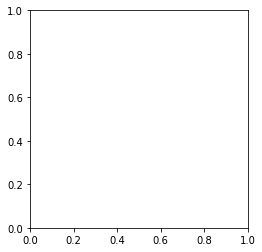

In [386]:
plt.imshow(torch.tensor(g) * j[7][0])

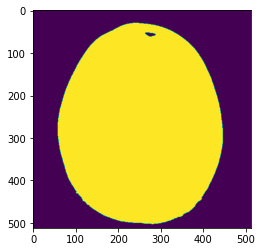

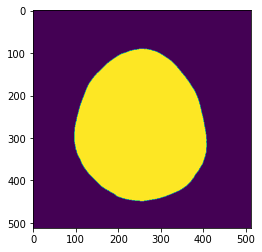

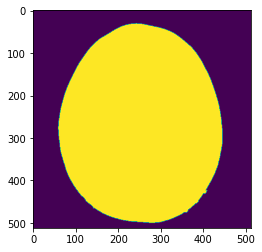

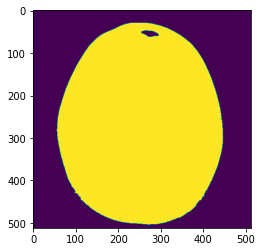

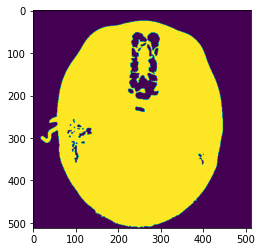

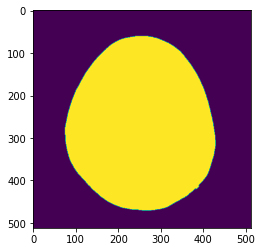

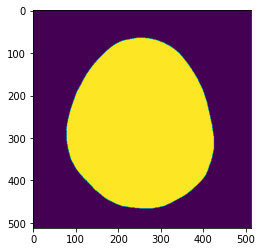

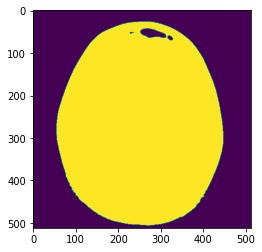

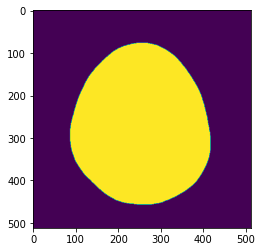

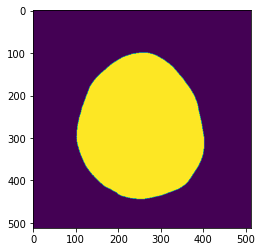

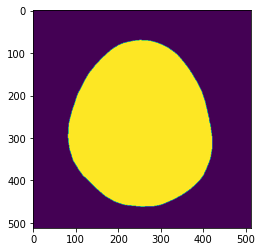

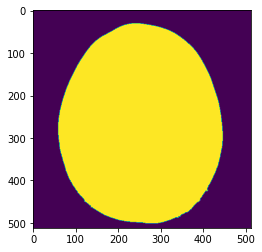

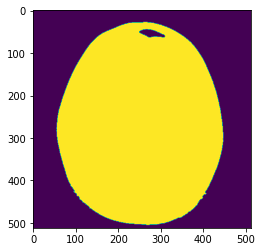

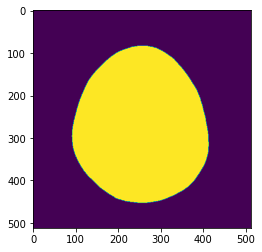

In [381]:
for i in range(14):
    plt.imshow(j[i][0])
    plt.show()

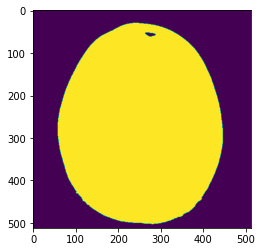

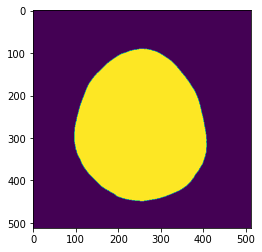

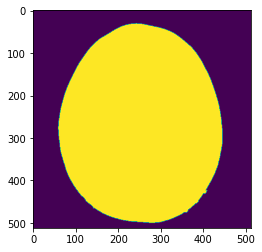

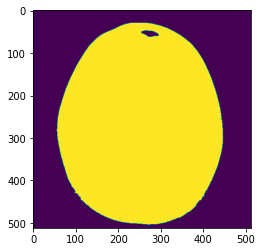

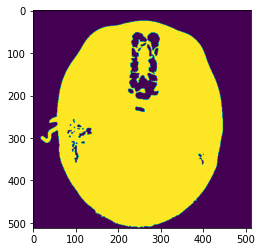

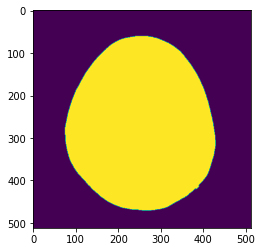

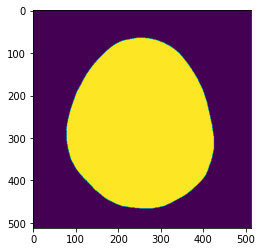

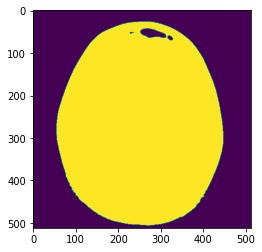

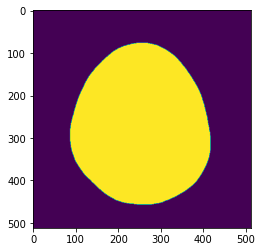

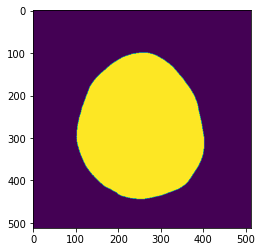

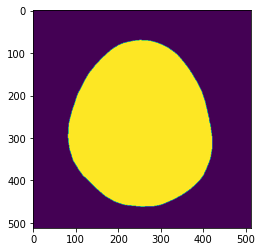

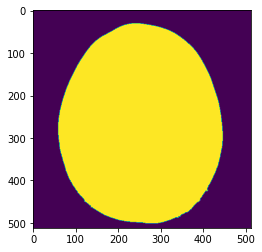

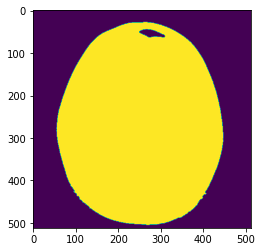

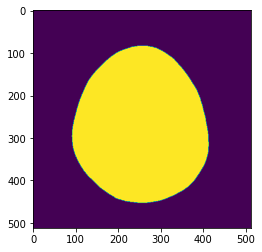

In [361]:
for i in range(14):
    plt.imshow(j[i][0])
    plt.show()

In [307]:
g.shape

(14, 512, 512)

In [305]:
k.shape

(14, 512, 512)

(-0.5, 511.5, 511.5, -0.5)

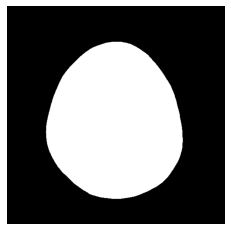

In [289]:
plt.imshow(k, 'gray')
plt.axis('off')

In [ ]:
skimage.measure.label(image)

In [231]:
image = skimage.measure.label(image)

image[image!=1]=0

In [230]:
np.unique(image, return_counts=True)

(array([0, 1, 2]), array([117362, 144646,    136]))

(-0.5, 511.5, 511.5, -0.5)

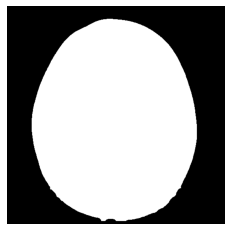

In [258]:
plt.imshow(image, 'gray')
plt.axis('off')

(-0.5, 511.5, 511.5, -0.5)

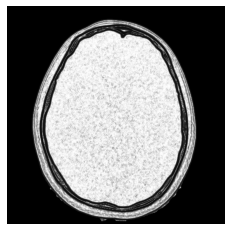

In [272]:
plt.imshow( 1/sobel(torch.tensor(g)) * image.astype('float32'), 'gray')
plt.axis('off')

In [ ]:
1/sobel(torch.tensor(g)).squeeze()

In [388]:
g.shape

(14, 1, 512, 512)

In [401]:
t = ROI_map_extract(torch.tensor(g)) / sobel(torch.tensor(g))

In [403]:
t1 = (1 / sobel(torch.tensor(g))) * ROI_map_extract(torch.tensor(g))

In [404]:
torch.equal(t, t1)

True

In [396]:
t

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.

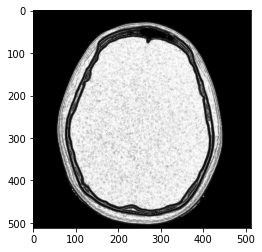

In [395]:
plt.imshow(t[7][0], 'gray')

(-0.5, 511.5, 511.5, -0.5)

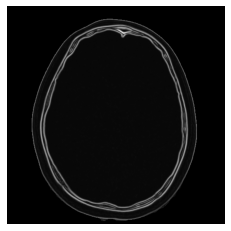

In [261]:
plt.imshow( sobel(torch.tensor(g)).squeeze() * image.astype('float32'), 'gray')
plt.axis('off')

In [255]:
(1/sobel(torch.tensor(g)).squeeze() * image.astype('float32')).max()

tensor(100.)

In [256]:
(1/sobel(torch.tensor(g)).squeeze() * image.astype('float32')).min()

tensor(0.)

TypeError: Invalid shape (14, 512, 512) for image data

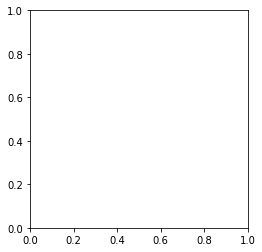

In [405]:
plt.imshow(g.squeeze(),'gray')

(-0.5, 511.5, 511.5, -0.5)

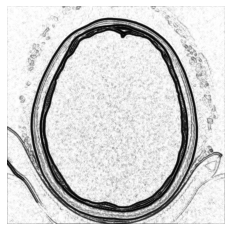

In [260]:
plt.imshow(1/k.squeeze(), 'gray')
plt.axis('off')

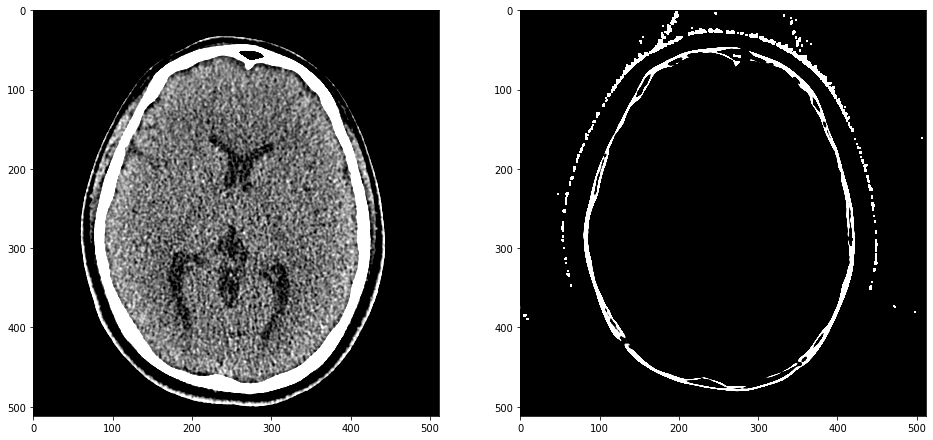

In [35]:
plt.figure(figsize=(16,16))

plt.subplot(121)
plt.imshow(dicom_denormalize(g).squeeze(), 'gray', vmin=0, vmax=80)

plt.subplot(122)
plt.imshow(dicom_denormalize(z).squeeze(), 'gray', vmin=0, vmax=80)

plt.show()

In [ ]:
plt.figure(figsize=(16,16))

plt.subplot(121)
plt.imshow(g.squeeze(), 'gray')

plt.subplot(122)
plt.imshow(p.squeeze(), 'gray')

plt.show()

In [269]:
loss = nn.MSELoss(size_average=None, reduce=False, reduction='mean')

In [266]:
loss = nn.MSELoss(size_average=None, reduce=True, reduction='mean')
input = torch.randn((1,1,320,320), requires_grad=True).round()
target = torch.ones((1,1,320,320))
output = loss(input, target)
# output.backward()

In [270]:
output = loss(input, target)

In [267]:
output.shape

torch.Size([])

In [268]:
output

tensor(2.0846, grad_fn=<MseLossBackward>)

In [271]:
torch.mean(output)

tensor(2.0846, grad_fn=<MeanBackward0>)

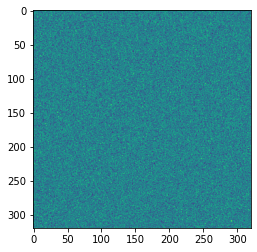

In [202]:
plt.imshow(input[0][0].detach().cpu())

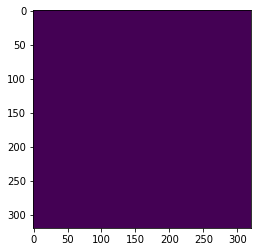

In [203]:
plt.imshow(target[0][0].detach().cpu())

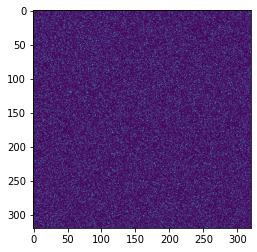

In [206]:
plt.imshow(output[0][0].detach().cpu())

In [207]:
output.shape

torch.Size([1, 1, 320, 320])